# Model cross evaluation using hmmlearn

_Etienne Ackermann, 08/05/2015_

The data can be downloaded from the [CRCNS](http://crcns.org/data-sets/hc/hc-3) (Collaborative Research in Computational Neuroscience) website, and the ```hc-3``` data set in particular.

### Summary

Note that both **gor01** and **vvp01** were recorded with a Neuralynx recording system at 32,552 Hz, then amplified 1000x, followed by 1–5 kHz bandpass filtering. It was then further downsampled to 1252 Hz, and stored in the .eeg file, which is a binary file with the same number of channels as in the raw data.  Has up to 32 (four shank probe) or 64 (eight shank probe) short integers (2 bytes, signed) every time step.  (One integer from each recording site, i.e. channel).  Actual number of channels is specified in the .xml file and is not always a multiple of 8 because bad channels (due to very high impedance or broken shank) were removed from the data. 

---

## Load observation data

At this point we are interested in learning from the data, and we do this by considering sequences of spike count observations. That is, each observation is a $u$-dimensional vector, where $u$ is the number of units that we recorded, with each element corresponds to the number of spikes observed within a time bin of 250 or 10 ms, depending on whether we are considering the behavioral, or the replay timescales.

In [1]:
import pickle

# load SWR spikes for both environments (binned in 10 ms):
with open('data/SWR_train1rn.pickle', 'rb') as f:
    SWR_train1 = pickle.load(f)
with open('data/SWR_train2rn.pickle', 'rb') as f:
    SWR_train2 = pickle.load(f)
    
with open('data/SWR_test1rn.pickle', 'rb') as f:
    SWR_test1 = pickle.load(f)
with open('data/SWR_test2rn.pickle', 'rb') as f:
    SWR_test2 = pickle.load(f)
    
# load training spike count data, binned in 250 ms bins:
with open('data/BVR_train1rn_noswr_noth1.pickle', 'rb') as f:
    BVR_train1 = pickle.load(f)
with open('data/BVR_train2rn_noswr_th1.pickle', 'rb') as f:
    BVR_train2 = pickle.load(f)    
    
# load testing spike count data, binned in 250 ms bins:
with open('data/BVR_test1rn_noswr_noth1.pickle', 'rb') as f:
    BVR_test1 = pickle.load(f)  
with open('data/BVR_test2rn_noswr_th1.pickle', 'rb') as f:
    BVR_test2 = pickle.load(f)

## Load Python modules and helper functions

In [2]:
import sys
sys.path.insert(0, '../')

import numpy as np
import pandas as pd
import pickle 
import seaborn as sns
#import yahmm as ym
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn


from matplotlib import pyplot as plt
from pandas import Series, DataFrame

from efunctions import * # load my helper functions

%matplotlib inline

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


In [3]:
def remove_empty_sequences(data):
    tmp = np.array(data)
    emptySequences = []
    num_sequences = tmp.shape[0]
    for ss in np.arange(0,num_sequences):
        if len(tmp[ss]) == 0:
            emptySequences.append(ss)
            
    print(emptySequences)
    for dd in np.arange(0,len(emptySequences)):
        idx = emptySequences[len(emptySequences)-dd-1]
        del data[idx]

In [4]:
def yahmmdata_to_hmmlearn_data(yahmmdata):
    SequenceLengths = []

    tmp = np.array(yahmmdata)
    num_sequences = tmp.shape[0]
    for ss in np.arange(0,num_sequences):
        SequenceLengths.append(len(tmp[ss]))

    numCells = np.array(tmp[0]).shape[1]
    
    TotalSequenceLength = np.array(SequenceLengths).sum()
    
    StackedData = np.zeros((TotalSequenceLength,numCells))
    rr = 0;
    for ss in np.arange(0,num_sequences):
        StackedData[rr:rr+SequenceLengths[ss],:] = np.array(tmp[ss])
        rr = rr+SequenceLengths[ss]
    
    print("{0} sequences stacked for hmmlearn".format(num_sequences))
    
    return SequenceLengths, StackedData


In [5]:
TrainingSequenceLengthsBVRtr2, StackedTrainingDataBVRtr2 = yahmmdata_to_hmmlearn_data(BVR_train2)
TrainingSequenceLengthsSWRtr2, StackedTrainingDataSWRtr2 = yahmmdata_to_hmmlearn_data(SWR_train2)
TestingSequenceLengthsSWRts2, StackedTestingDataSWRts2 = yahmmdata_to_hmmlearn_data(SWR_test2)
TestingSequenceLengthsBVRts2, StackedTestingDataBVRts2 = yahmmdata_to_hmmlearn_data(BVR_test2)

TrainingSequenceLengthsBVRtr1, StackedTrainingDataBVRtr1 = yahmmdata_to_hmmlearn_data(BVR_train1)
TestingSequenceLengthsSWRts1, StackedTestingDataSWRts1 = yahmmdata_to_hmmlearn_data(SWR_test1)
TrainingSequenceLengthsSWRtr1, StackedTrainingDataSWRtr1 = yahmmdata_to_hmmlearn_data(SWR_train1)
remove_empty_sequences(BVR_test1)
TestingSequenceLengthsBVRts1, StackedTestingDataBVRts1 = yahmmdata_to_hmmlearn_data(BVR_test1) # error ??? will investigate

63 sequences stacked for hmmlearn
357 sequences stacked for hmmlearn
321 sequences stacked for hmmlearn
48 sequences stacked for hmmlearn
171 sequences stacked for hmmlearn
348 sequences stacked for hmmlearn
314 sequences stacked for hmmlearn
[15]
155 sequences stacked for hmmlearn


In [6]:
# learn (fit) models to data:

NStates = 15

# using BVR1 training data
hmm15_1 = hmm.PoissonHMM(n_components=NStates, n_iter=20, init_params='stm', params='stm', verbose=True)
hmm15_1.fit(StackedTrainingDataBVRtr1, lengths=TrainingSequenceLengthsBVRtr1)

# using BVR2 training data
hmm15_2 = hmm.PoissonHMM(n_components=NStates, n_iter=20, init_params='stm', params='stm', verbose=True)
hmm15_2.fit(StackedTrainingDataBVRtr2, lengths=TrainingSequenceLengthsBVRtr2)

# using SWR1 training data
hmm15_swr1 = hmm.PoissonHMM(n_components=NStates, n_iter=20, init_params='stm', params='stm', verbose=True)
hmm15_swr1.fit(StackedTrainingDataSWRtr1, lengths=TrainingSequenceLengthsSWRtr1)

# using SWR2 training data
hmm15_swr2 = hmm.PoissonHMM(n_components=NStates, n_iter=20, init_params='stm', params='stm', verbose=True)
hmm15_swr2.fit(StackedTrainingDataSWRtr2, lengths=TrainingSequenceLengthsSWRtr2)


         2      251609.4316       +6812.4042
         3      253306.1724       +1696.7408
         4      254398.3441       +1092.1717
         5      255045.8262        +647.4821
         6      255369.5074        +323.6812
         7      255527.9506        +158.4433
         8      255627.2075         +99.2568
         9      255716.9773         +89.7698
        10      255792.4340         +75.4567
        11      255838.4931         +46.0591
        12      255879.8412         +41.3481
        13      255921.4141         +41.5729
        14      255964.2562         +42.8420
        15      256013.2275         +48.9713
        16      256050.1548         +36.9273
        17      256079.5941         +29.4393
        18      256134.0290         +54.4349
        19      256194.3197         +60.2907
         2       72028.0568       +2377.4952
         3       72533.4290        +505.3723
         4       72716.0484        +182.6193
         5       72810.1555         +94.1071
         6

PoissonHMM(algorithm='viterbi', init_params='stm', means_prior=0,
      means_weight=0, n_components=15, n_iter=20, params='stm',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=True)

[]

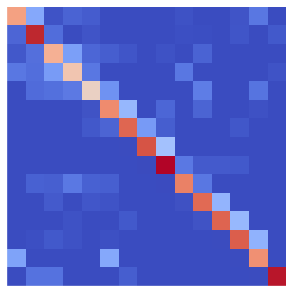

In [31]:
tmat = hmm15_2.transmat_
# sort model states:
new_order = [0]
rem_states = np.arange(1,NStates).tolist()
cs = 0

for ii in np.arange(0,NStates-1):
    nstilde = np.argmax(tmat[cs,rem_states])
    ns = rem_states[nstilde]
    rem_states.remove(ns)
    cs = ns
    new_order.append(cs)
    
tmatnew = tmat[:, new_order][new_order]

meanmat = hmm15_2.means_[new_order,:]
new_order = np.argsort(meanmat[-1,:])
meanmat = meanmat[:,new_order]

sns.set(rc={'figure.figsize': (5, 5),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
#f, (ax1, ax2) = plt.subplots(1,2)
f, ax1 = plt.subplots(1,1)

ax1.imshow(tmatnew,interpolation="none", cmap='coolwarm')
ax1.grid(False)
ax1.set_xticklabels('')
ax1.set_yticklabels('')

#ax2.imshow(np.log(meanmat.T),interpolation="none", cmap='PuBu')    



In [43]:
np.percentile(TestingSequenceLengthsBVRts2, [100, 75, 50, 25, 0])*.250

array([ 8.25,  5.  ,  4.25,  3.5 ,  2.75])

In [75]:
####################################################################
# BVR test {1,2} in BVR train {1}
####################################################################

bvr2_in_bvr1_log_prob_test = np.zeros((len(TestingSequenceLengthsBVRts2),1))
bvr1_in_bvr1_log_prob_test = np.zeros((len(TestingSequenceLengthsBVRts1),1))

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsBVRts2))
for ee in np.arange(0,len(TestingSequenceLengthsBVRts2)):
    obs = StackedTestingDataBVRts2[seqlimits[ee]:seqlimits[ee+1],:]
    bvr2_in_bvr1_log_prob_test[ee] = hmm15_1.score(obs)

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsBVRts1))
for ee in np.arange(0,len(TestingSequenceLengthsBVRts1)):
    obs = StackedTrainingDataBVRtr1[seqlimits[ee]:seqlimits[ee+1],:]
    bvr1_in_bvr1_log_prob_test[ee] = hmm15_1.score(obs)

####################################################################
# SWR test {1,2} in BVR train {2}
####################################################################

swr2_in_bvr2_log_prob_test = np.zeros((len(TestingSequenceLengthsSWRts2),1))
swr1_in_bvr2_log_prob_test = np.zeros((len(TestingSequenceLengthsSWRts1),1))

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsSWRts2))
for ee in np.arange(0,len(TestingSequenceLengthsSWRts2)):
    obs = StackedTestingDataSWRts2[seqlimits[ee]:seqlimits[ee+1],:]*25
    swr2_in_bvr2_log_prob_test[ee] = hmm15_2.score(obs)

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsSWRts1))
for ee in np.arange(0,len(TestingSequenceLengthsSWRts1)):
    obs = StackedTestingDataSWRts1[seqlimits[ee]:seqlimits[ee+1],:]*25
    swr1_in_bvr2_log_prob_test[ee] = hmm15_2.score(obs)
    
####################################################################
# SWR test {1,2} in BVR train {1,2} --- log odds
####################################################################

swr1ts_in_bvr1tr_log_prob = np.zeros((len(TestingSequenceLengthsSWRts1),1))
swr2ts_in_bvr1tr_log_prob = np.zeros((len(TestingSequenceLengthsSWRts2),1))

swr1ts_in_bvr2tr_log_prob = np.zeros((len(TestingSequenceLengthsSWRts1),1))
swr2ts_in_bvr2tr_log_prob = np.zeros((len(TestingSequenceLengthsSWRts2),1))

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsSWRts1))
for ee in np.arange(0,len(TestingSequenceLengthsSWRts1)):
    obs = StackedTestingDataSWRts1[seqlimits[ee]:seqlimits[ee+1],:]*25
    swr1ts_in_bvr1tr_log_prob[ee] = hmm15_1.score(obs)
    swr1ts_in_bvr2tr_log_prob[ee] = hmm15_2.score(obs)
    
seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsSWRts2))
for ee in np.arange(0,len(TestingSequenceLengthsSWRts2)):
    obs = StackedTestingDataSWRts2[seqlimits[ee]:seqlimits[ee+1],:]*25
    swr2ts_in_bvr1tr_log_prob[ee] = hmm15_1.score(obs)
    swr2ts_in_bvr2tr_log_prob[ee] = hmm15_2.score(obs)

####################################################################
# BVR test {1,2} in SWR train {1}
####################################################################

bvr2_in_swr1_log_prob_test = np.zeros((len(TestingSequenceLengthsBVRts2),1))
bvr1_in_swr1_log_prob_test = np.zeros((len(TestingSequenceLengthsBVRts1),1))

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsBVRts2))
for ee in np.arange(0,len(TestingSequenceLengthsBVRts2)):
    obs = StackedTestingDataBVRts2[seqlimits[ee]:seqlimits[ee+1],:]
    bvr2_in_swr1_log_prob_test[ee] = hmm15_swr1.score(obs)

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsBVRts1))
for ee in np.arange(0,len(TestingSequenceLengthsBVRts1)):
    obs = StackedTestingDataBVRts1[seqlimits[ee]:seqlimits[ee+1],:]
    bvr1_in_swr1_log_prob_test[ee] = hmm15_swr1.score(obs)

####################################################################
# BVR test {1,2} in SWR train {2}
####################################################################

bvr2_in_swr2_log_prob_test = np.zeros((len(TestingSequenceLengthsBVRts2),1))
bvr1_in_swr2_log_prob_test = np.zeros((len(TestingSequenceLengthsBVRts1),1))

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsBVRts2))
for ee in np.arange(0,len(TestingSequenceLengthsBVRts2)):
    obs = StackedTestingDataBVRts2[seqlimits[ee]:seqlimits[ee+1],:]
    bvr2_in_swr2_log_prob_test[ee] = hmm15_swr2.score(obs)

seqlimits = np.cumsum(np.array([0] + TestingSequenceLengthsBVRts1))
for ee in np.arange(0,len(TestingSequenceLengthsBVRts1)):
    obs = StackedTestingDataBVRts1[seqlimits[ee]:seqlimits[ee+1],:]
    bvr1_in_swr2_log_prob_test[ee] = hmm15_swr2.score(obs)    

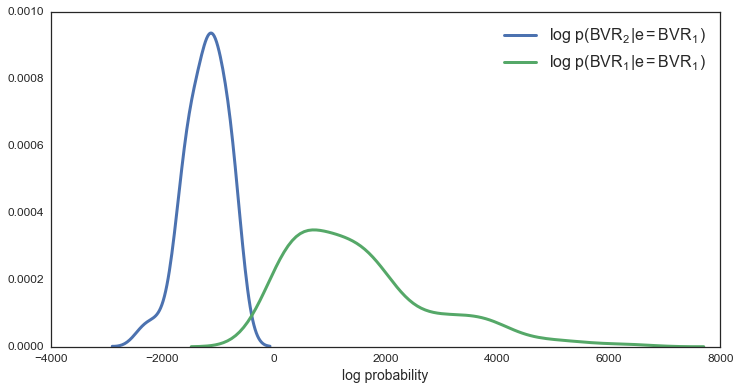

In [54]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


sns.set(rc={'figure.figsize': (12, 6),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1) = plt.subplots(1,1)

sns.distplot( bvr2_in_bvr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p($BVR_2 | e=BVR_1$)"}  );
sns.distplot( bvr1_in_bvr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p($BVR_1 | e=BVR_1$)"} );

#ax1.set_title('BVR_test{1,2} in BVR_train{1}')

#saveFigure("figures/?.pdf")

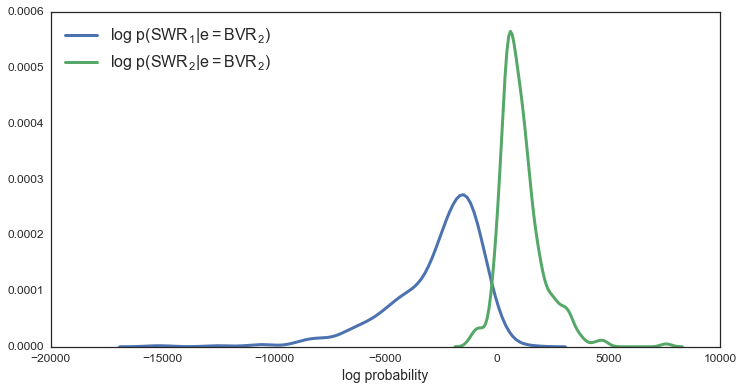

In [56]:
sns.set(rc={'figure.figsize': (12, 6),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1 ) = plt.subplots(1,1)

sns.distplot( swr1_in_bvr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p($SWR_1 | e=BVR_2$)"} );
sns.distplot( swr2_in_bvr2_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p($SWR_2 | e=BVR_2$)"} );

#ax1.set_title('SWR_test{1,2} in BVR_train{2}')

#saveFigure("figures/?.pdf")

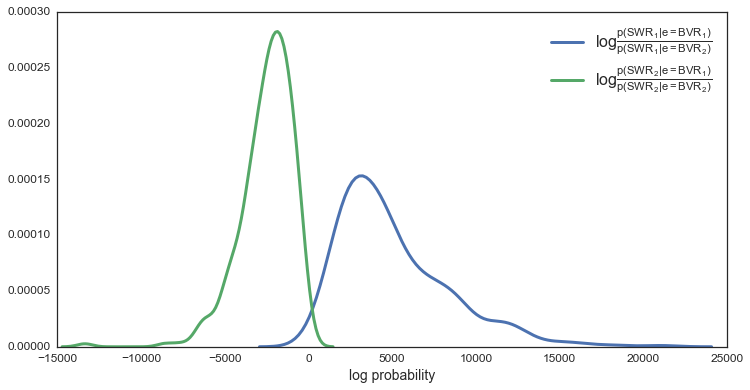

In [67]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


sns.set(rc={'figure.figsize': (12,6),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1) = plt.subplots(1)

sns.distplot( swr1ts_in_bvr1tr_log_prob - swr1ts_in_bvr2tr_log_prob, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, 
             kde_kws={"lw": 3, "label": r"$log \frac{p(SWR_1 | e=BVR_1)}{p(SWR_1 | e=BVR_2)}$"} );
sns.distplot( swr2ts_in_bvr1tr_log_prob - swr2ts_in_bvr2tr_log_prob, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', 
             ax=ax1, kde_kws={"lw": 3, "label": r"$log \frac{p(SWR_2 | e=BVR_1)}{p(SWR_2 | e=BVR_2)}$"}  );

#ax1.set_title('log odds of SWR (test) sequences in BVR (train) models')

#saveFigure("figures/?.pdf")


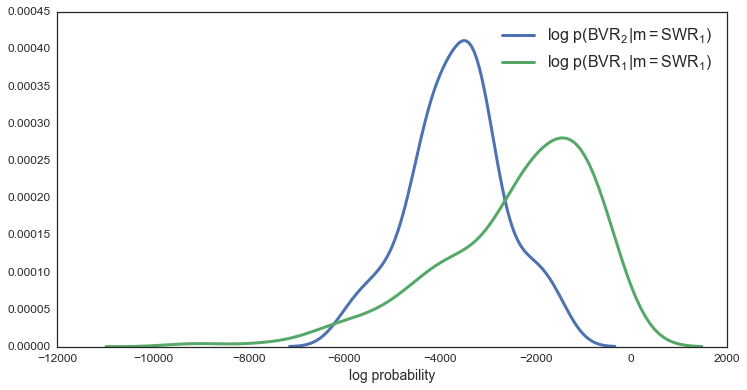

In [77]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


sns.set(rc={'figure.figsize': (12, 6),'lines.linewidth': 3, 'font.size': 16, 'axes.labelsize': 14, 'legend.fontsize': 16, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")
f, ( ax1) = plt.subplots(1,1)

sns.distplot( bvr2_in_swr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p($BVR_2 | m=SWR_1$)"}  );
sns.distplot( bvr1_in_swr1_log_prob_test, bins=20, hist=False, kde=True, rug=False, axlabel='log probability', ax=ax1, kde_kws={"lw": 3, "label": "log p($BVR_1 | m=SWR_1$)"} );

#ax1.set_title('BVR_test{1,2} in BVR_train{1}')

#saveFigure("figures/?.pdf")